#PBMC1k 10Xv2 data were collected from 10XG database and processed with kallisto bus

kallisto bus -i index/Homo_sapiens.GRCh38.cdna.all.kidx -x 10Xv2 -t 8 -o kallisto_pbmc1kv2_out \
                                           10XGv2v3/pbmc_1k_v2_fastqs/pbmc_1k_v2_S1_L001_R1_001.fastq.gz \
                                           10XGv2v3/pbmc_1k_v2_fastqs/pbmc_1k_v2_S1_L001_R2_001.fastq.gz \
                                           10XGv2v3/pbmc_1k_v2_fastqs/pbmc_1k_v2_S1_L002_R1_001.fastq.gz \
                                           10XGv2v3/pbmc_1k_v2_fastqs/pbmc_1k_v2_S1_L002_R2_001.fastq.gz

bustools sort -t {THREAD} -o kallisto_pbmc1kv2_out/output.sort.bus kallisto_pbmc1kv2_out/output.bus

bustools text -o kallisto_pbmc1kv2_out/output.sort.txt kallisto_pbmc1kv2_out/output.sort.bus

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

In [2]:
import sys, collections

In [3]:
#load human transcript

tr2g = {}
trlist = []
with open('../index/tr2g_human') as f:
    for line in f:
        l = line.split()
        tr2g[l[0]] = l[1]
        trlist.append(l[0])

genes = list(set(tr2g[t] for t in tr2g))

# load equivalence classes
ecs = {}
with open('../kallisto_pbmc1kv2_out/matrix.ec') as f:
    for line in f:
        l = line.split()
        ec = int(l[0])
        trs = [int(x) for x in l[1].split(',')]
        ecs[ec] = trs
        
def ec2g(ec):
    if ec in ecs:
        return list(set(tr2g[trlist[t]] for t in ecs[ec]))        
    else:
        return []

In [4]:
# load test dataset

cell_gene = collections.defaultdict(lambda: collections.defaultdict(float))
pbar=None
pumi=None
with open('../kallisto_pbmc1kv2_out/output.sort.txt') as f:
    gs = set()
    for line in f:
        l = line.split()
        barcode,umi,ec,count = line.split()
        ec = int(ec)
        
        if barcode == pbar:
            # same barcode
            if umi == pumi:
                # same UMI, let's update with intersection of genelist
                gl = ec2g(ec)
                gs.intersection_update(gl)
            else:
                # new UMI, process the previous gene set
                for g in gs:
                    cell_gene[barcode][g] += 1.0/len(gs)
                # record new umi, reset gene set
                pumi = umi
                gs = set(ec2g(ec))
        else:
            # work with previous gene list
            for g in gs:
                cell_gene[pbar][g] += 1.0/len(gs)
            
            if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
                del cell_gene[pbar]
            
            pbar = barcode
            pumi = umi
            
            gs = set(ec2g(ec))
    #remember the last gene
    for g in gs:
        cell_gene[pbar][g] += 1.0/len(gs)
        
    if sum(cell_gene[pbar][g] for g in cell_gene[pbar]) < 10:
        del cell_gene[pbar]



In [5]:
barcode_hist = collections.defaultdict(int)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    s = len([cg[g] for g in cg])
    barcode_hist[barcode] += s
    

In [6]:
#barcode_hist

1849


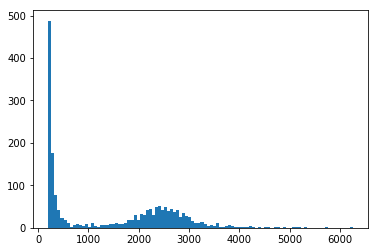

In [7]:
bcv = [x for b,x in barcode_hist.items() if x > 200 and x < 20000]
_ = plt.hist(bcv,bins=100)
print(len(bcv))

In [9]:
bad_barcode = [x for x in barcode_hist if  barcode_hist[x] <= 2000]
len(bad_barcode)/len(cell_gene)

0.9794534727253907

In [10]:
s = 0
bad_s = 0
bad_barcode_set = set(bad_barcode)
for barcode in cell_gene:
    cg = cell_gene[barcode]
    cgs =  sum(cg[g] for g in cg)
    s += cgs
    if barcode in bad_barcode_set:
        bad_s += cgs
    

In [11]:
bad_s/s

0.31811075316674414

In [12]:
outfile = '../kallisto_pbmc1kv2_out/matrix.mtx'

gene_to_id = dict((g,i+1) for i,g in enumerate(genes))
barcodes_to_use = [b for b,x in barcode_hist.items() if x > 2000 and x < 10000]

num_entries = 0
for barcode in barcodes_to_use:
    num_entries += len([x for x in cell_gene[barcode].values() if round(x)>0])



In [13]:
with open(outfile, 'w') as of:
    of.write('%%MatrixMarket matrix coordinate real general\n%\n')
    #number of genes
    of.write("%d %d %d\n"%(len(genes), len(barcodes_to_use), num_entries))
    bcid = 0
    for barcode in barcodes_to_use:
        bcid += 1
        cg = cell_gene[barcode]
        gl = [(gene_to_id[g],round(cg[g])) for g in cg if round(cg[g]) > 0]
        gl.sort()
        for x in gl:
            of.write("%d %d %d\n"%(x[0],bcid,x[1]))
    

In [14]:
gene_names = {}
with open('../index/mart_export_human.txt') as f:
    f.readline()
    for line in f:
        g,t,gn = line.split()
        gene_names[g] = gn


In [15]:
id_to_genes = dict((i,g) for (g,i) in gene_to_id.items())
gl = []
for i in range(1,len(genes)+1):
    g = id_to_genes[i]
    gid = g[:g.find('.')]
    if gid in gene_names:
        gn = gene_names[gid]
    else:
        gn = ''
    gl.append((g,gn))

with open('../kallisto_pbmc1kv2_out/genes.tsv','w') as of:
    for g,gn in gl:
        of.write("%s\t%s\n"%(g,gn))
        
with open('../kallisto_pbmc1kv2_out/barcodes.tsv','w') as of:
    of.write('\n'.join(x + '-1' for x in barcodes_to_use))
    of.write('\n')

In [16]:
import numpy as np
import pandas as pd
import scanpy.api as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = '../kallisto_pbmc1kv2_out/pbmc1k.h5ad'
sc.settings.set_figure_params(dpi=80)

adata = sc.read_10x_mtx('../kallisto_pbmc1kv2_out/', var_names='gene_symbols', cache=False)
adata.var_names_make_unique()

scanpy==1.3.2 anndata==0.6.10 numpy==1.15.1 scipy==1.1.0 pandas==0.23.4 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.


In [17]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=2)
mito_genes = [name for name in adata.var_names if name.startswith('mt-')]
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse to transform to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
adata.obs['n_counts'] = adata.X.sum(axis=1).A1

filtered out 23483 genes that are detected in less than 2 cells


In [18]:
adata = adata[adata.obs['n_genes'] < 5000, :]
adata = adata[adata.obs['percent_mito'] < 0.25, :]

In [19]:
adata

View of AnnData object with n_obs × n_vars = 794 × 16812 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'

In [20]:
sc.pp.log1p(adata)
#sc.pp.regress_out(adata, ['n_counts', 'percent_mito'])

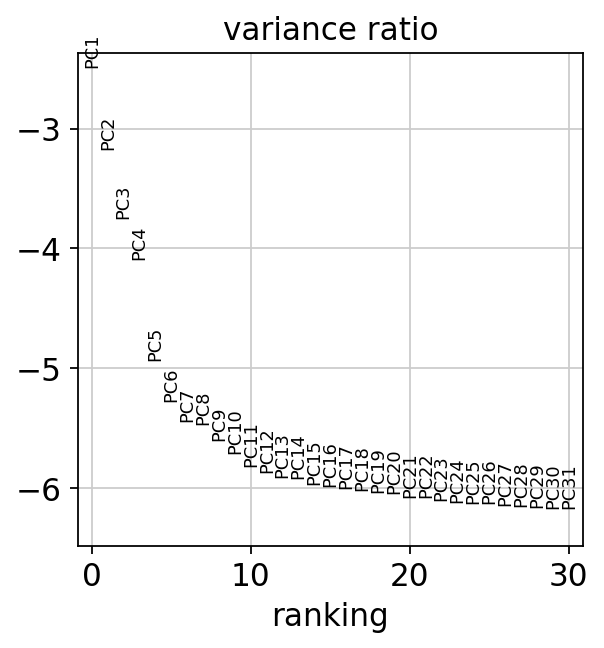

In [21]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [22]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished (0:00:06.68) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:02.24) --> added
    'X_umap', UMAP coordinates (adata.obsm)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.08) --> found 9 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)


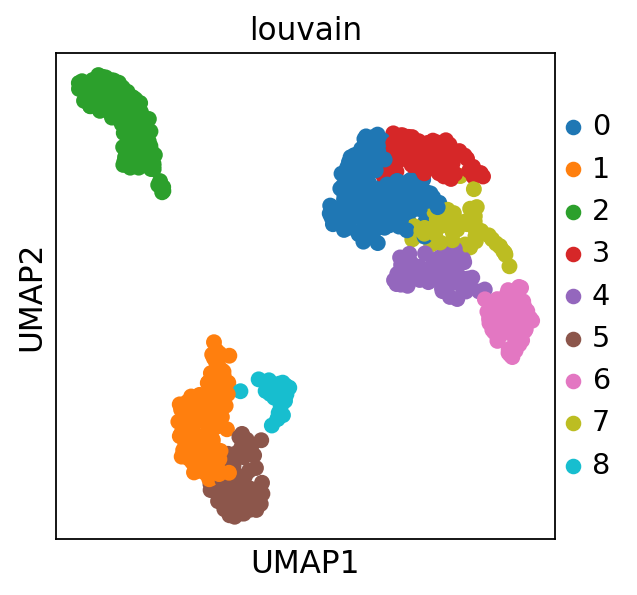

In [24]:
sc.tl.louvain(adata, resolution=1)
sc.pl.umap(adata, color=['louvain'])

computing tSNE
    using 'X_pca' with n_pcs = 20
    using sklearn.manifold.TSNE with a fix by D. DeTomaso
    finished (0:00:21.77) --> added
    'X_tsne', tSNE coordinates (adata.obsm)


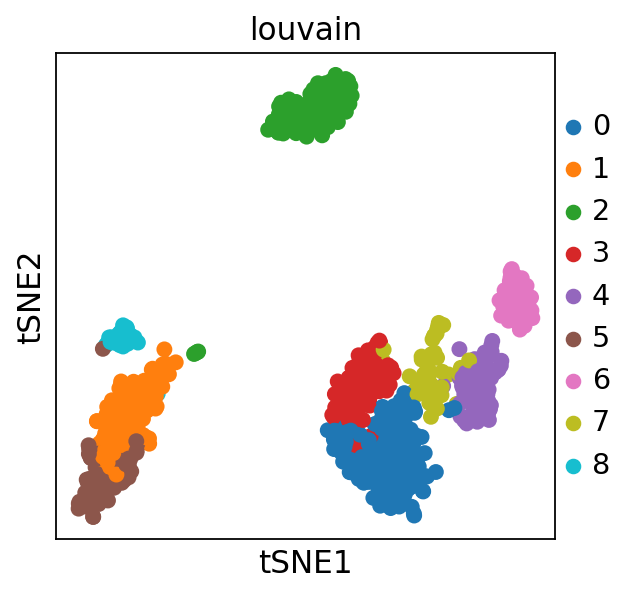

In [25]:
sc.tl.tsne(adata, n_pcs=20)
sc.pl.tsne(adata, color=['louvain'])

In [26]:
sc.tl.rank_genes_groups(adata, 'louvain', method='t-test', corr_method='benjamini-hochberg')

ranking genes
    finished (0:00:00.46) --> added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids


In [27]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
#pd.DataFrame({group + '_' + key: result[key][group]
#    for group in groups for key in ['names', 'scores','logfoldchanges','pvals','pvals_adj']}).head(20)


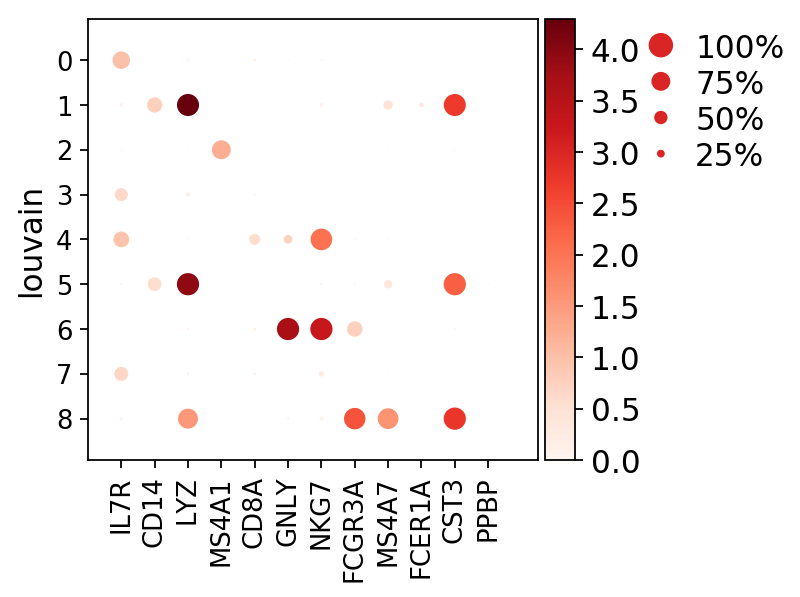

In [28]:
marker_genes = ['IL7R','CD14','LYZ','MS4A1','CD8A','GNLY','NKG7','FCGR3A','MS4A7','FCER1A','CST3','PPBP']
sc.pl.dotplot(adata, marker_genes, groupby='louvain')

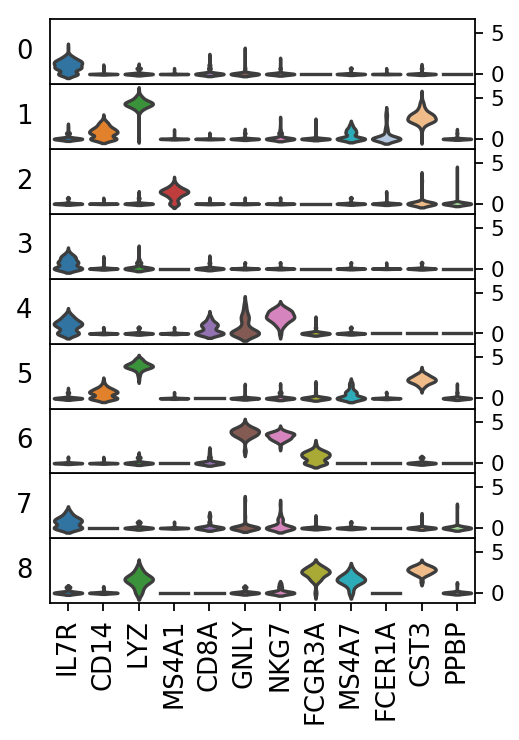

In [29]:
sc.pl.stacked_violin(adata, marker_genes, groupby='louvain', rotation=90)